# Neuromodulation example

This neuromodulation creates a small network of neurons. We also use the reaction diffusion model by Anu G Nair 2015.

To generate the ```reaction_diffusion.json``` file in ```data/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20211026/``` from the xml file we run ```data/convert_sbml_to_json.sh```

To get the RxD functionality of the ```DA_syn``` we must specify the "RxD" block in the connectivity block of the network configuration. See ```data/connectivity.json```

```
    "channel_parameters":
		"RxD": {
		    "species_name": "DA",
		    "flux_variable": "open",
		    "region": "internal",
            "weight_scaling": 1e9,
		},

     ...
     }
```

## Network setup

This simulation models bath appliation of dopamine to the network. The concentrations starts low, then at 2 seconds it increases.

In [1]:
import os
from snudda import Snudda

neuron_path = os.path.join("data", "dspn")
network_path = os.path.join("networks", "neuromodulation_bath")
connectivity_path = os.path.join("data", "connectivity.json")

snudda = Snudda(network_path=network_path)
si = snudda.init_tiny(neuron_paths=neuron_path, neuron_names="dspn", number_of_neurons=[4], 
                      connection_config=connectivity_path, random_seed=12345)

# si.network_data["regions"]["Cube"]["neurons"]["dspn"]["reaction_diffusion"] = "reaction_diffusion.json"
si.network_data["regions"]["Cube"]["neurons"]["dspn"]["reaction_diffusion"] = "data/JSON/reaction_diffusion_D1.json"

si.network_data["regions"]["Cube"]["neurons"]["dspn"]["modulation"] = "test-modulation.json"
si.network_data["regions"]["Cube"]["neurons"]["dspn"]["modulation_key"] = "abc"

si.write_json()

snudda.create_network()

Reading connectivity from data/connectivity.json
Adding neurons: dspn from dir data/dspn
Writing networks/neuromodulation_bath/network-config.json
Writing networks/neuromodulation_bath/network-config.json
Placing neurons
Network path: networks/neuromodulation_bath
Reading SNUDDA_DATA=None from networks/neuromodulation_bath/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_bath/network-synapses.hdf5
No n_putative_points and putative_density, setting n_putative_points = 90
(this must be larger than the number of neurons you want to place)
Generating 90 points for networks/neuromodulation_bath/mesh/Cube-cube-mesh-3.6763882578080044e-05.obj
Filtering, keeping inside points: 5 / 35
neuron_name = 'dspn_0', num = 4, neuron_path = 'data/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20211026'
stop_parallel disabled, to keep pool running.

Execution time: 0.0s
Touch detection
Network path: networks/neuromodulation_bath
Reading SNUDDA_

In [2]:
input_config = os.path.join("data", "input_v5_bath.json")
snudda.setup_input(input_config=input_config)

Setting up inputs, assuming input.json exists
Reading SNUDDA_DATA=None from networks/neuromodulation_bath/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_bath/network-synapses.hdf5
Writing input spikes to networks/neuromodulation_bath/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/neuromodulation_bath/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_bath/network-synapses.hdf5
!!! Warning, combining definition of cortical_background with cortical_background input for neuron dspn_0 0 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background with thalamic_background input for neuron dspn_0 0 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical input for neuron dspn_0 0 (meta modified by input_config)
!!! Warning, combining definition of cortical_background with cortical_backgroun

In [3]:
sim_time = 4.0
n_workers = 4
sim_config = "data/DA-bath-experiment.json"
mech_dir = "/home/hjorth/BasalGangliaData/data/neurons/mechanisms"

run_str = f"mpirun -n {n_workers} snudda simulate {network_path} --time {sim_time} --simulation_config {sim_config} --mechdir {mech_dir} --enable_rxd_neuromodulation"
print(run_str)

mpirun -n 4 snudda simulate networks/neuromodulation_bath --time 4.0 --simulation_config data/DA-bath-experiment.json --mechdir /home/hjorth/BasalGangliaData/data/neurons/mechanisms


In [ ]:
os.system(run_str)

### Add PKA and DA recordings
Here we add recordings from a compartment that receives synaptic input from its neighbour. This has been checked by looking at the synapse_connection matrix (snudda_load command).

## Load the data and plot

In [4]:
from snudda.utils import SnuddaLoadSimulation

output_file = os.path.join(network_path, "simulation", "output.hdf5")
nd = SnuddaLoadSimulation(output_file)
time = nd.get_time()
data_pka = nd.get_data("PKAc", 1)[0][1]
data_da = nd.get_data("DA", 1)[0][1]
data_da_external = nd.get_data("DA", 0)[0][0]

# This is saved with add_rxd_internal_concentration_recording_all -- check that it worked 
data_pka_all0 = nd.get_data("PKAc", 0)[0][0]

Loading networks/neuromodulation_bath/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
2: (dspn_0, p7aa400d6, mf702205f)


In [5]:
data_types = nd.list_data_types(0)
all_species_data = nd.get_all_data(neuron_id=0, exclude=["spikes", "voltage"])
time = nd.get_time()

In [6]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe"  # Do not save plots in the notebook, they can get BIG

fig = go.Figure()
for data_type in all_species_data:
    fig.add_trace(go.Scatter(x=time, y=all_species_data[data_type][0][0].T[0], name=data_type))

fig.update_layout(xaxis_title="Time (s)", yaxis_title="Concentration", width=1000, height=800,
                 font={"size":18},  # General font size for all elements
                 legend={"font":{"size":16}},  # Specific font size for legend
                 xaxis={"title":{"font":{"size":20}}, "tickfont":{"size":14}},  # X-axis title and tick labels
                 yaxis={"title":{"font":{"size":20}}, "tickfont":{"size":14}})   # Y-axis title and tick labels

fig.show()

Loading networks/neuromodulation_bath/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
2: (dspn_0, p7aa400d6, mf702205f)
Saving figure to networks/neuromodulation_bath/figures/spike-raster.png


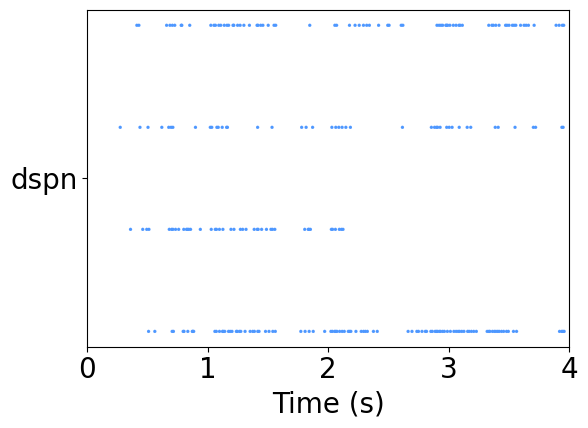

In [20]:
from snudda.plotting import SnuddaPlotSpikeRaster2
fig_file_raster = f"spike-raster.png"

time_range_zoom = (0,sim_time)
spr = SnuddaPlotSpikeRaster2(network_path=network_path)

spr.plot_spike_raster(fig_file=fig_file_raster, time_range=time_range_zoom)

Saving figure networks/neuromodulation_bath/figures/spike-frequency-pop-units0.pdf


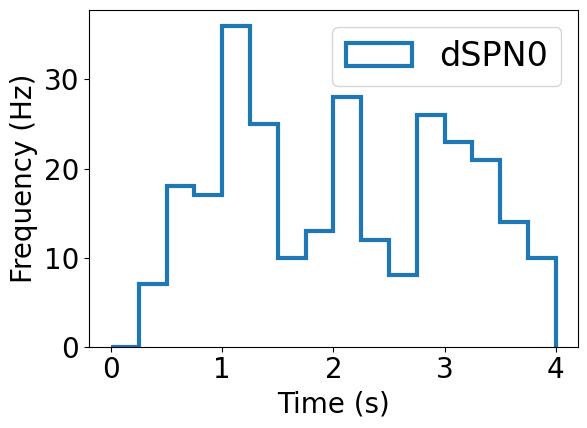

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

In [29]:
spr.plot_spike_histogram(label_text="dSPN", bin_size=0.25)


Loading network info from networks/neuromodulation_bath/network-synapses.hdf5
Loading input info from networks/neuromodulation_bath/input-spikes.hdf5
Loading networks/neuromodulation_bath/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
2: (dspn_0, p7aa400d6, mf702205f)
Plotting traces: [0, 1, 2, 3]
Plotted 4 traces (total 4)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/neuromodulation/networks/neuromodulation_bath/figures/Network-voltage-trace--dspn-0-1-2-3.pdf


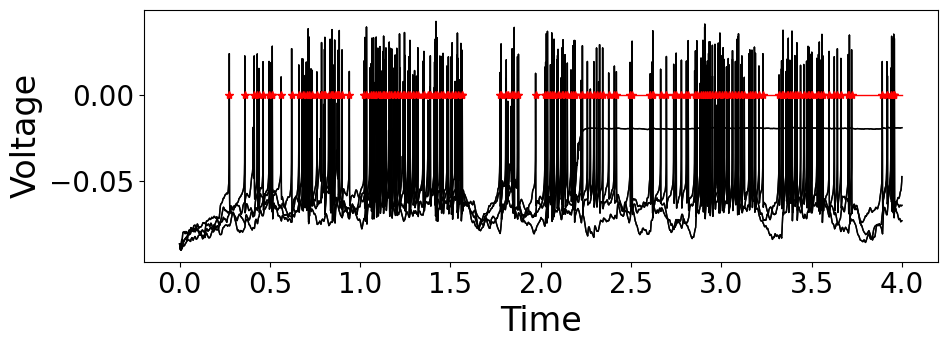

In [21]:
%matplotlib inline

sim_file = os.path.join(network_path, "simulation", "output.hdf5")

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(0,sim_time),fig_size=(10,4))

Plotting traces: [0]
Plotted 1 traces (total 4)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/neuromodulation/networks/neuromodulation_bath/figures/Network-voltage-trace--dspn-0.pdf


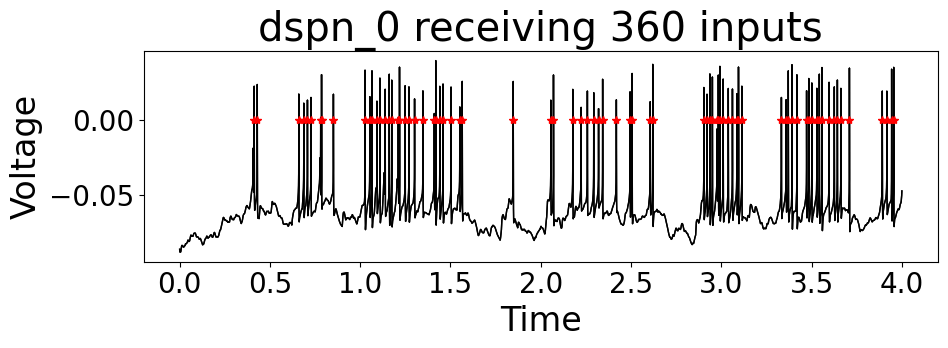

Plotting traces: [1]
Plotted 1 traces (total 4)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/neuromodulation/networks/neuromodulation_bath/figures/Network-voltage-trace--dspn-1.pdf


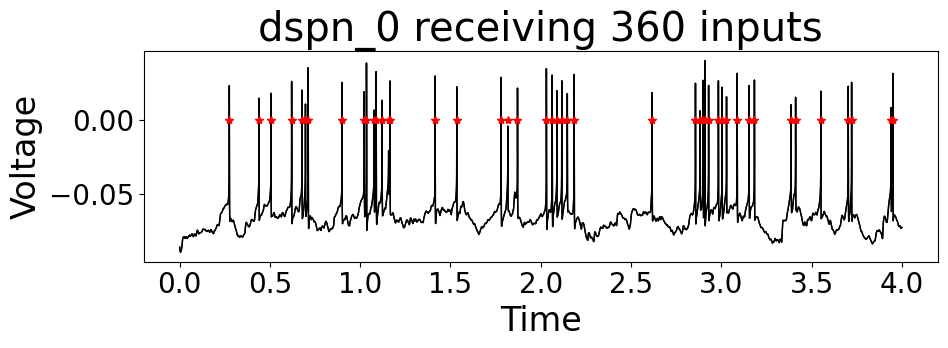

In [22]:
ax0 = pt.plot_traces(offset=0, time_range=(0,sim_time),fig_size=(10,4), trace_id=0)
ax1 = pt.plot_traces(offset=0, time_range=(0,sim_time),fig_size=(10,4), trace_id=1)